In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
from pathlib import Path
import os
from MitoCode_Functions import GetData, GetVolume

In [3]:
def Dist(pointOne, pointTwo): 
    a = 0 
    for i in range(len(pointOne)):  # this allows us to consider it for an n dimensional array
        a += (pointOne[i] - pointTwo[i])**2
    return np.sqrt(a)

In [4]:
class node: 
    def __init__(self, dat, pointer, dist, conn): 
        self.start = dat 
        self.next = pointer
        self.dist = dist
        self.conn = conn

In [5]:
# getting the files 
# /home.

nodeDist, nodeLists, skelePos, compList = GetData("/home/biratal/Desktop/Biolab/PRE96/tif1")
# nodeDist1, nodeList1, skelePos1, compList1 = GetData("/home/biratal/Desktop/Biolab/PRE96/tif2")

In [6]:
def cleanNodeDist(nodeDist):  # function to clean the nodeDist, as it is has different columns
    a = nodeDist[nodeDist.columns[0]]
    lis = np.array(list(a.items()), dtype = object)
    A = []

    for i in lis: 
        A.append([i[0], i[1]])
    nlis = np.array(lis, dtype = object)
    X = []
    Y = []
    dist = []

    for i in range(len(nlis)): 
        x, y = nlis[i][0]
        X.append(x)
        Y.append(y)
        dist.append(nlis[i][1])

    X = np.array(X)
    Y = np.array(Y)
    dist = np.array(dist)

    return pd.DataFrame({"X": X, "Y":Y, "dist":dist})

nodeTree = cleanNodeDist(nodeDist)

In [19]:
nodeTree = nodeTree[0:100]

In [20]:
def getVolumeAndGroup(nodeTree, compList):
    nodeTree["Volume"] = None
    nodeTree["Group"] = None
    ntv = nodeTree.values
    clv = compList.values
    for i in ntv: 
        for j in clv:
            if i[0] == j[0] or i[1] == j[0]: 
                i[3] = j[2]
                i[4] = j[1]
    nodeTree = pd.DataFrame(ntv, columns=["X", "Y", "dist", "Volume", "Group"])
    return nodeTree

nodeTree = getVolumeAndGroup(nodeTree, compList)

/tmp/ipykernel_11987/3248666089.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodeTree["Volume"] = None
/tmp/ipykernel_11987/3248666089.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodeTree["Group"] = None


In [21]:

def createNodeList(nodeTree): # creates a list of nodes from a dataframe and returns it
    arr = np.array(nodeTree.values)
    startArr = arr[:, 0] # node 1
    nextArr = arr[:, 1] # node 2 
    distArr = arr[:, 2] # distance 

    # nodes with connections
    nodeList = []
    for i in range(len(startArr)): 
        nodeList.append(node(startArr[i], nextArr[i], distArr[i], []))

    # nodes without connections

    for i in nextArr: 
        if i not in startArr: 
            nodeList.append(node(i, -1, 0, []))

    # if a mitochondria branches out from one point to several, we need a dummy node that points to it

    bunchem = []
    for i in startArr: # ones with many branches but nothing pointng to it
        if np.count_nonzero(startArr == i) > 1: 
            if i not in nextArr: 
                bunchem.append(i)

    bunchem = list(set(bunchem))
    all = np.append(nextArr, startArr)
    count = max(all) + 1

    for i in bunchem: 
        nodeList.append(node(count, i, 0, [] ))
        count += 1

    return nodeList

# find the start points of the mitochondria branching
def getOrigins(nodeList): # returns originNodeList and a list with the origins in it
    origins = []
    startArr2 = []
    nextArr2 = []

    for i in nodeList: 
        startArr2.append(i.start)
        nextArr2.append(i.next) 

    for i in startArr2: 
        if i not in nextArr2: 
            origins.append(i)

    originNodeList = []

    for i in origins: 
        for j in nodeList: 
            if j.start == i: 
                originNodeList.append(j)
    
    return originNodeList, origins

def getConnections(nodeList): 
    for i in nodeList: 
        tempList = []
        for j in nodeList:
            if i.next == j.start: 
                tempList.append(j)
        i.conn = tempList
    
nodeList = createNodeList(nodeTree)
originNodeList, origins = getOrigins(nodeList)
getConnections(nodeList)

In [22]:
# recursive function to get the different branches

mnemonicList = []

def getPath(conList, nodeOne, print = True): # list of connections, start node
    if print == True: 
        if nodeOne.next == -1:
            return conList.append(nodeOne.start)
        for i in nodeOne.conn: 
            conList.append(i.start)
            (getPath(conList, i))
        return conList
    else: 
        if nodeOne.next == -1:
            return conList.append(nodeOne)
        for i in nodeOne.conn: 
            conList.append(i)
            (getPath(conList, i, False))
        return conList

def printPath(a): 
    i = 0 
    while i < len(a) - 1:
        if a[i + 1] != a[i]: 
            print(a[i], end = "-> ")
            i += 1
        else: 
            print(a[i])
            i += 2
            print("  \t", end = "")
            
k = -2
a = getPath([nodeList[k].start], nodeList[k], print = True)
b = getPath([nodeList[k]], nodeList[k], print = False)


In [23]:
bol = [(1, 3), (5, 1), (3, 1)]
if 1 in bol: 
    print("hi")

In [24]:
def getBranchdf (a):
    dfList = []
    pointList = []
    for i in a: 
        if i not in pointList: 
            pointList.append(i)
            try: 
                dfList.append(nodeTree.loc[nodeTree["X"] == i]) 
            except: 
                IndexError
    return pd.concat(dfList)
    
def getGlobalDfList(originNodeList):
    globalDfList = []
    for k in range(len(originNodeList)): 
        a = getBranchdf(getPath([originNodeList[k].start], originNodeList[k], print = True))
        globalDfList.append(a)
    return globalDfList

<function __main__.getGlobalDfList(originNodeList)>

In [31]:
def numOfNodes(df): 
    return len(set(np.append(df["X"].values, df["Y"].values)))

In [30]:
for i in globalDfList: 
    nodeNum = numOfNodes(i)
    lis = [nodeNum] * len(i)
    i["numOfNodes"] = lis

NameError: name 'globalDfList' is not defined

In [32]:
# cleaning data for node coordinates

A = []
for i in nodeLists.columns: 
    A.append(float(i))
    
Blist = []
Blist.append(A)
for i in nodeLists.values: 
    Blist.append(list(i))

nodeCoordinates = pd.DataFrame(np.array(Blist), columns= ["x", "y", "z"])

In [60]:
skelePos.loc[skelePos["line_id"] ==0]

# getting the average of width 
# getting the average and the sd 

,line_id,point_id,x,y,z,width_(um),pixel_intensity
0,0,0,5.40800,1.352,2.00000,0.25711,678.83333
1,0,1,5.30806,1.456,2.22222,0.43469,749.33333
2,0,2,5.23027,1.560,2.33333,0.47513,1127.16667
3,0,3,5.20000,1.664,2.29630,0.44517,1234.66667
4,0,4,5.16994,1.768,2.16667,0.51875,1386.00000
5,0,5,5.09600,1.872,2.00000,0.45677,1647.83333


In [33]:
def plotMito(PreOrPost, j = -1): # takes in a pre or post image
    x = []
    y = []
    z = []
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111, projection='3d')
    if j != -1: 
        a = PreOrPost.loc[PreOrPost["line_id"] == j]
        x.append(a["x"].values)
        y.append(a["y"].values)
        z.append(a["z"].values)
    else:
        for k in range(PreOrPost["line_id"].max()):
        # for k in range(100):
            a = PreOrPost.loc[PreOrPost["line_id"] == k]
            x.append(a["x"].values)
            y.append(a["y"].values)
            z.append(a["z"].values)
    for i in range(len(x)): 
        plt.scatter(x[i], y[i] ,z[i], marker="." )
    plt.xlabel("X (um)")
    plt.ylabel("Y (um)")

    return fig

In [34]:
def getPost(skelePos, coordinates, node):
    coors = coordinates[node]
    a = coors[0]
    b = coors[1]
    c = coors[2]

    first = skelePos.loc[skelePos["x"] == a]
    if len(first) > 1: 
        second = first.loc[first["y"] == b]
        second["node"] = node
        if len(second) > 1: 
            third = second.loc[second["z"] == c]
            third["node"] = node
            return third
        else: 
            return second 
    else: 
        first["node"] = node
        return first

df = []
for i in range(114):
    a = getPost(skelePos, nodeCoordinates.values, i)
    df.append(a)

test = pd.concat(df)

/tmp/ipykernel_11987/3743461085.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second["node"] = node
/tmp/ipykernel_11987/3743461085.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second["node"] = node
/tmp/ipykernel_11987/3743461085.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

In [35]:
test.loc[test["line_id"] == 0]

,line_id,point_id,x,y,z,width_(um),pixel_intensity,node


In [36]:
def plotMitoWithNode(PreOrPost, nodeDf, down = 0, up = 100): # takes in a pre or post image
    x = []
    y = []
    z = []

    nX = []
    nY = []
    nZ = []

    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111, projection='3d')

    for k in range(down, up):
        a = PreOrPost.loc[PreOrPost["line_id"] == k]
       
        x.append(a["x"].values)
        y.append(a["y"].values)
        z.append(a["z"].values)

        na = nodeDf.loc[nodeDf["line_id"] == k]
        nX.append(na["x"].values)
        nY.append(na["y"].values)
        nZ.append(na["z"].values)

    for i in range(len(x)): 
        plt.scatter(x[i], y[i] ,z[i], marker=".", color = "blue" )
        plt.scatter(nX[i], nY[i], nZ[i], color = 'red')
    plt.xlabel("X (um)")
    plt.ylabel("Y (um)")
    return 1

In [37]:
def plotMitoWithNode2(PreOrPost, nodeDf, down = 0, up = 100): # takes in a pre or post image
    x = []
    y = []
    z = []

    nX = []
    nY = []
    nZ = []

    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111, projection='3d')

    for k in range(down, up):
        a = PreOrPost.loc[PreOrPost["line_id"] == k]
       
        x.append(a["x"].values)
        y.append(a["y"].values)
        z.append(a["z"].values)

        na = nodeDf.loc[nodeDf["line_id"] == k]
        nX.append(na["x"].values)
        nY.append(na["y"].values)
        nZ.append(na["z"].values)

    for i in range(len(x)): 
        plt.scatter(x[i], y[i] ,z[i], marker=".", color = "blue" )
        plt.scatter(nX[i], nY[i], nZ[i], color = 'red')
    plt.xlabel("X (um)")
    plt.ylabel("Y (um)")
    return 1

In [38]:
skelePos.loc[skelePos["line_id"] == 3].mean()[""]

KeyError: ''

In [39]:
skelePos[skelePos["line_id"] == 0]

,line_id,point_id,x,y,z,width_(um),pixel_intensity
0,0,0,0.31200,7.384,2.00000,0.08327,110.00000
1,0,1,0.38573,7.280,2.31481,0.25726,93.66667
2,0,2,0.41214,7.176,2.59259,0.23886,200.00000
3,0,3,0.41986,7.072,2.79630,0.36456,136.00000
4,0,4,0.44647,6.968,2.92593,0.32325,172.83333
5,0,5,0.52406,6.864,2.98148,0.39938,280.66667
6,0,6,0.62400,6.760,3.00000,0.40412,335.33333


In [40]:
dt =[]
for i in range(70): 
    a = skelePos.loc[skelePos["line_id"] == i]
    width = skelePos.loc[skelePos["line_id"] == i].mean()["width_(um)"]
    pixelIntensity = skelePos.loc[skelePos["line_id"] == i].mean()["pixel_intensity"]
    a["avgwidth"] = [width] * len(a)
    a["avgpixelIntensity"] = [pixelIntensity] * len(a)

    dt.append(a)

/tmp/ipykernel_11987/3586055512.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a["avgwidth"] = [width] * len(a)
/tmp/ipykernel_11987/3586055512.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a["avgpixelIntensity"] = [pixelIntensity] * len(a)
/tmp/ipykernel_11987/3586055512.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

1

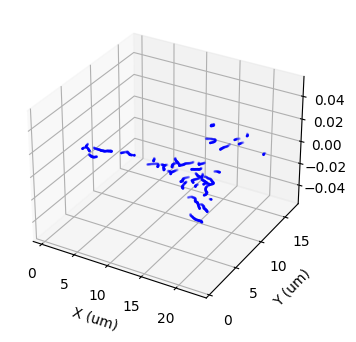

In [41]:
plotMitoWithNode(skelePos, test, 0, 50)

In [42]:
indexList = []
for i in range(len(nodeCoordinates)): 
    indexList.append(i)
    
nodeCoordinates["node"] = indexList 
# nodeCoordinates # contains node positions and node name

In [43]:
nodeCoordinates

,x,y,z,node
0,16.848,12.376,15.5,0
1,16.848,12.064,15.5,1
2,13.936,10.816,15.5,2
3,13.624,9.776,15.5,3
4,15.600,7.696,15.5,4
...,...,...,...,...
688,1.560,7.072,3.0,688
689,0.624,6.760,3.0,689
690,21.112,4.368,3.0,690
691,20.904,4.368,3.0,691


In [111]:
w = []
pi = []
for i in dt: 
    w.append(i["avgwidth"].values[0])
    pi.append(i["avgpixelIntensity"].values[0])


Text(0, 0.5, 'functional, pixel intensity')

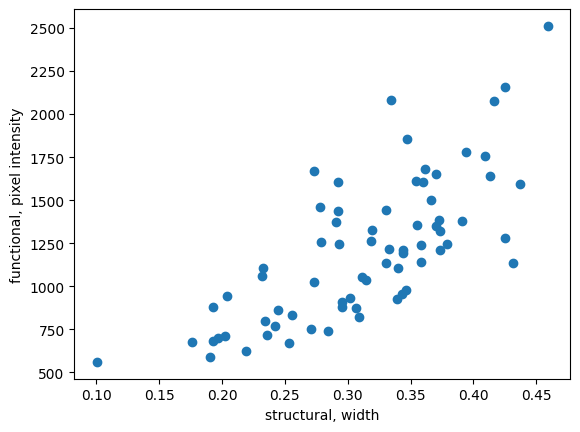

In [113]:
plt.scatter(w, pi)
plt.xlabel("structural, width")
plt.ylabel("functional, pixel intensity")